In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
from datetime import datetime
import time
import ta

from plot import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from data import db

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2



SYMBOL = "BTC"
START = "2017"
END = "2024"

DB = db.connect_db("database", interval="1h")
data = DB.get_data(SYMBOL, START, END)
#data = data.loc[start:end]


In [2]:

def create_stage_3(data):
    data['stage_1_change'] = (data['stage_1'] != data['stage_1'].shift()).cumsum()
    data['group'] = np.where(data['stage_1'] != 0, data['stage_1_change'], np.nan)
    data['group'] = data['group'].fillna(method='ffill')
    group_confirmed = data.groupby('group')['stage_2_1'].transform('max') == 1
    data['stage_3'] = np.where((group_confirmed) & (data['stage_1'] != 0), data['stage_1'], 0)
    data.drop(columns=['stage_1_change', 'group'], inplace=True)


def set_labels(data):
    seuil_gap = 3
    seuil_rel = 3.5
    data['stage_1'] = np.where(data['gap_sma5_sma6'] > 0, 1, -1)
    data['stage_2_1'] = data['rel_gap_sma2_sma6'].apply(lambda x : 1 if (x >= seuil_rel) or (x <= -seuil_rel) else 0)
    data['stage_2_2'] = data['gap_sma5_sma6'].apply(lambda x : 1 if (x >= seuil_gap) or (x <= -seuil_gap) else 0)
    create_stage_3(data)
    data['stage_3'] = data['stage_3'].replace({-1 : 1})
    data.drop(columns=['stage_2_1', 'stage_2_2'], inplace=True)
    

In [3]:
from ml_model.pipeline import get_pipeline, save_pipeline

pipeline = get_pipeline()
#save_pipeline()

print(f" shape 1 : {data.shape}")
data = pipeline.fit_transform(data)
set_labels(data)

 shape 1 : (62600, 5)


In [4]:
print(f" shape 1 : {data.shape}")

 shape 1 : (62313, 23)


In [5]:
from ml_model.split import PurgedKFold


N = data.shape[0]
test_size = int(0.8 * N)
test_data = data.iloc[test_size:]
data = data.iloc[:test_size]

X_test = test_data.drop(columns=['stage_3'])
y_test = test_data['stage_3']

X = data.drop(columns=['stage_3'])
y = data['stage_3']


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from ml_model.evaluation import Evaluation, plot_validation_curve, plot_learning_curve


# Instancier le PurgedKFold
n_splits = 10
embargo = 300  # Définir selon la taille de votre ensemble de données
cv_results = {}
cv = PurgedKFold(n_splits=n_splits, embargo=embargo)

model = RandomForestClassifier(random_state=42)
scores = ['accuracy', 'precision', 'roc_auc']
#for score in scores:
#    cv_results[score] = cross_val_score(model, X, y, cv=cv, scoring=score)

#cv_df = pd.DataFrame(cv_results)
#px.box(cv_df)

In [7]:
#plot_learning_curve(model, X, y, cv=cv)

##  Catboost

In [8]:
import catboost    
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import eval_metric

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler


seed = 5
train_pool = Pool(data=X, label=y)
eval_pool = Pool(data=X_test, label=y_test)

base_model = CatBoostClassifier(iterations = 700, depth=3,
                                od_type='Iter', od_wait=30,
                                eval_metric="Accuracy",
                                verbose=False, random_state=seed
                                )

base_model.fit(train_pool, eval_set=eval_pool,
               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[[6150 1107]
 [1465 3741]]
Accuracy : 0.79
Taux d'erreur : 0.21
Précision: 0.79
Rappel: 0.79
F1-Score: 0.79
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7257
           1       0.77      0.72      0.74      5206

    accuracy                           0.79     12463
   macro avg       0.79      0.78      0.79     12463
weighted avg       0.79      0.79      0.79     12463

Log Loss: 0.45


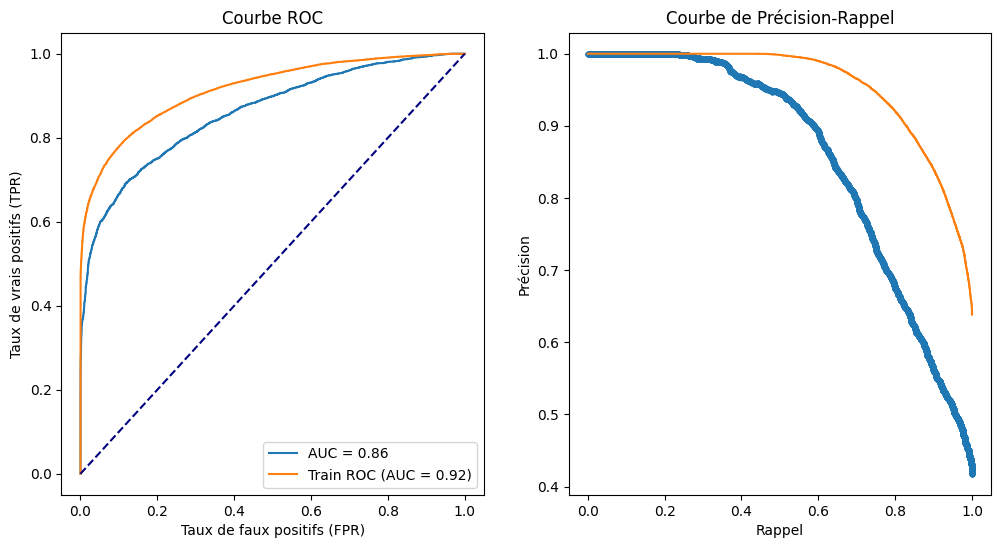

In [9]:
evaluation = Evaluation(model=base_model, X_test=X_test, X_train=X, y_test=y_test, y_train=y)
evaluation.get_metric()
evaluation.auc_roc()

In [10]:

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'eval_metric': 'Accuracy',
        "verbose": False
    }   

    model = catboost.CatBoostClassifier(**params, random_seed=seed)
    model.fit(train_pool, verbose=0, eval_set=eval_pool, plot=False)
    #model.fit(train_pool, verbose=0, eval_set=eval_pool, early_stopping_rounds=50, plot=False)
    y_pred = model.predict(eval_pool)
    y_proba = model.predict_proba(eval_pool)
    
    return eval_metric(eval_pool.get_label(), y_pred, 'Accuracy')


sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-10-17 12:29:52,779] A new study created in memory with name: no-name-d054db6c-2870-43b6-87ba-3d5fa3642826
[I 2024-10-17 12:30:06,094] Trial 0 finished with value: 0.7918639171948969 and parameters: {'iterations': 712, 'learning_rate': 0.005114484048333241, 'l2_leaf_reg': 0.008079896808319472, 'subsample': 0.7756573845414456}. Best is trial 0 with value: 0.7918639171948969.
[I 2024-10-17 12:30:19,294] Trial 1 finished with value: 0.7969991173874669 and parameters: {'iterations': 734, 'learning_rate': 0.011170844473762483, 'l2_leaf_reg': 8.376388146302443, 'subsample': 0.8424148692924316}. Best is trial 1 with value: 0.7969991173874669.
[I 2024-10-17 12:30:28,030] Trial 2 finished with value: 0.7929070047340127 and parameters: {'iterations': 507, 'learning_rate': 0.009361008480057652, 'l2_leaf_reg': 0.023589137648150627, 'subsample': 0.8645248536920208}. Best is trial 1 with value: 0.7969991173874669.
[I 2024-10-17 12:30:36,644] Trial 3 finished with value: 0.7866484794993179 and

In [11]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
importance = vis.plot_param_importances(study)
importance.show()

In [12]:
vis.plot_slice(study)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[[6102 1155]
 [1415 3791]]
Accuracy : 0.79
Taux d'erreur : 0.21
Précision: 0.79
Rappel: 0.79
F1-Score: 0.79
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      7257
           1       0.77      0.73      0.75      5206

    accuracy                           0.79     12463
   macro avg       0.79      0.78      0.79     12463
weighted avg       0.79      0.79      0.79     12463

Log Loss: 0.44


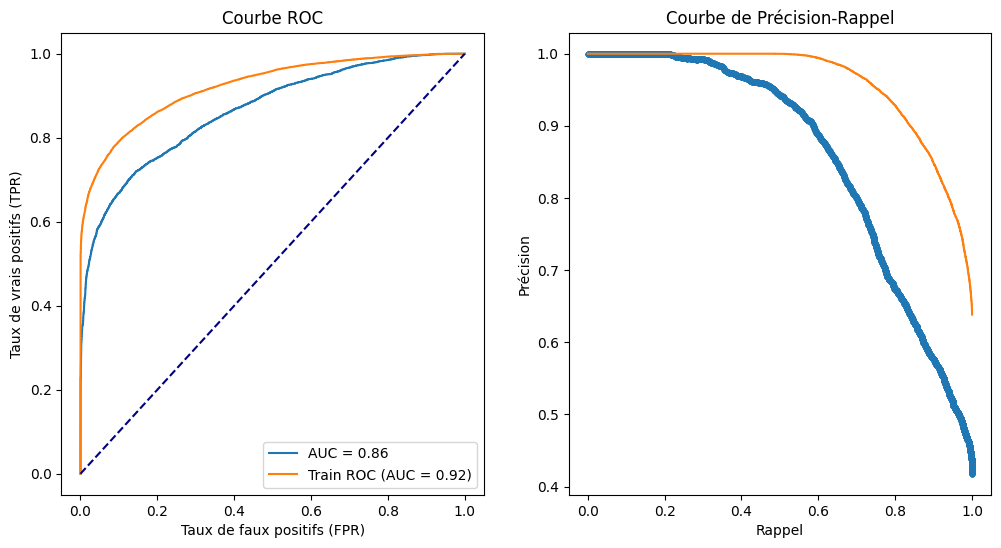

In [13]:
#study.best_params = 

best_params = study.best_params

train_pool = Pool(data=X, label=y)
eval_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(**best_params, verbose=False, random_state=seed)
model.fit(train_pool, eval_set=eval_pool, plot=True)

evaluation = Evaluation(model=model, X_test=X_test, X_train=X, y_test=y_test, y_train=y)
evaluation.get_metric()
evaluation.auc_roc()

## Backtest

In [14]:
X_test['stage_3'] = model.predict(X_test)
X_test['stage_3'].value_counts()

stage_3
0    7517
1    4946
Name: count, dtype: int64

In [20]:
import plotly.express as px

X_test_f = X_test.loc['2024-01-13' : '2024-10-13'].copy()
backtest = pd.DataFrame()

backtest['return'] = X_test_f['ret']
backtest['proba'] = model.predict_proba(X_test_f)[:,1]

backtest['pred'] = np.where(backtest['proba'] > 0.6, 1,
                            np.where(backtest['proba'] < 0.4,
                                     -1, 0)
                            )
backtest['stage_1'] = X_test['stage_1']
#backtest['stage_1'] = np.sign(X_test['stage_1'].diff().fillna(0))
backtest['position'] = backtest['stage_1'] * backtest['pred']

backtest['cum_ret'] = (1 + backtest['return']).cumprod()
backtest['strategy'] = backtest['return'] * backtest['position']
backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()


px.line(backtest[['cum_ret', 'strategy_cum_ret']])

In [16]:
backtest[backtest['position'] != 0][['proba', 'position']]

,proba,position
time,,
2024-01-16 11:00:00,0.208632,-1.0
2024-01-17 22:00:00,0.261238,1.0
2024-01-21 06:00:00,0.190101,-1.0
2024-01-22 07:00:00,0.390047,1.0
2024-01-25 03:00:00,0.190566,-1.0
...,...,...
2024-09-22 09:00:00,0.136904,1.0
2024-09-26 03:00:00,0.135251,1.0
2024-09-30 00:00:00,0.145802,1.0


In [17]:
backtest.groupby('stage_1')['strategy'].apply(lambda x : (1+x).prod())

stage_1
-1.0    0.978417
 0.0    1.000000
 1.0    1.035135
Name: strategy, dtype: float64

In [18]:
backtest

,return,proba,pred,stage_1,position,cum_ret,strategy,strategy_cum_ret
time,,,,,,,,
2024-01-13 00:00:00,0.000445,0.994782,1,0.0,0.0,1.000445,0.0,1.000000
2024-01-13 01:00:00,-0.002989,0.996089,1,0.0,0.0,0.997455,-0.0,1.000000
2024-01-13 02:00:00,-0.003370,0.997960,1,0.0,0.0,0.994093,-0.0,1.000000
2024-01-13 03:00:00,0.001880,0.998503,1,0.0,0.0,0.995961,0.0,1.000000
2024-01-13 04:00:00,0.005399,0.998415,1,0.0,0.0,1.001339,0.0,1.000000
...,...,...,...,...,...,...,...,...
2024-10-12 15:00:00,-0.001226,0.680330,1,0.0,0.0,1.476238,-0.0,1.012794
2024-10-12 16:00:00,-0.001479,0.701256,1,0.0,0.0,1.474054,-0.0,1.012794
2024-10-12 17:00:00,0.000625,0.652756,1,0.0,0.0,1.474975,0.0,1.012794


In [21]:
import os


path = r"C:\Users\Dell\Desktop\CedAlgo\C-Syst\app\system\decision\strategies"

save_pipeline(os.path.join(path, "fpipeline.pkl"))
model.save_model(os.path.join(path, "catboost_model.cbm"))


# test

In [28]:
import joblib

# Save pipeline
joblib.dump(get_pipeline(), "fpipeline.pkl")

# Exporter le modèle
model.save_model("catboost_model.cbm")

In [21]:
from catboost import CatBoostClassifier

# Créer une instance de CatBoostClassifier
loaded_model = CatBoostClassifier()

# Importer le modèle sauvegardé
loaded_model.load_model("catboost_model.cbm")


In [22]:
# Utiliser le modèle importé pour faire des prédictions
predictions = loaded_model.predict(X_test)
predictions

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)